<a href="https://colab.research.google.com/github/amndalsr/OnlineGamingAnxietyAnalysis/blob/main/An%C3%A1liseDaAnsiedadeEmJogosOnline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dados = pd.read_csv('/content/GamingStudy_data.csv', encoding='ISO-8859-1')
dados.head()

,S. No.,Timestamp,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,...,Birthplace,Residence,Reference,Playstyle,accept,GAD_T,SWL_T,SPIN_T,Residence_ISO3,Birthplace_ISO3
0,1,42052.00437,0,0,0,0,1,0,0,Not difficult at all,...,USA,USA,Reddit,Singleplayer,Accept,1,23,5.0,USA,USA
1,2,42052.00680,1,2,2,2,0,1,0,Somewhat difficult,...,USA,USA,Reddit,Multiplayer - online - with strangers,Accept,8,16,33.0,USA,USA
2,3,42052.03860,0,2,2,0,0,3,1,Not difficult at all,...,Germany,Germany,Reddit,Singleplayer,Accept,8,17,31.0,DEU,DEU
3,4,42052.06804,0,0,0,0,0,0,0,Not difficult at all,...,USA,USA,Reddit,Multiplayer - online - with online acquaintanc...,Accept,0,17,11.0,USA,USA
4,5,42052.08948,2,1,2,2,2,3,2,Very difficult,...,USA,South Korea,Reddit,Multiplayer - online - with strangers,Accept,14,14,13.0,KOR,USA


In [44]:
pontuacoes_gad = dados['GAD_T'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(pontuacoes_gad)
centroides = kmeans.cluster_centers_
centroides_ordenados = sorted(centroides.ravel())
limite_baixo = (centroides_ordenados[0] + centroides_ordenados[1]) / 2
limite_alto = (centroides_ordenados[1] + centroides_ordenados[2]) / 2

def categorizar_ansiedade(pontuacao):
    if pontuacao < limite_baixo:
        return "baixa"
    elif pontuacao < limite_alto:
        return "média"
    else:
        return "alta"

dados['GAD_T_cat'] = dados['GAD_T'].apply(categorizar_ansiedade)

In [37]:
X = dados.drop('GAD_T_cat', axis=1)
y = dados['GAD_T_cat']
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=0)

caracteristicas_numericas = X_treino.select_dtypes(include=['int64', 'float64']).columns.tolist()
caracteristicas_categoricas = X_treino.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

transformador_numerico = Pipeline(steps=[
    ('imputador', SimpleImputer(strategy='mean')),
    ('normalizador', StandardScaler())
])

transformador_categorico = Pipeline(steps=[
    ('imputador', SimpleImputer(strategy='constant', fill_value='faltante')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, caracteristicas_numericas),
        ('cat', transformador_categorico, caracteristicas_categoricas)
    ])

X_treino = preprocessador.fit_transform(X_treino)
X_teste = preprocessador.transform(X_teste)


In [38]:
modelo = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=0)
modelo.fit(X_treino, y_treino)


MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=0)

Acurácia: 0.9974006683995544
              precision    recall  f1-score   support

        alta       0.98      1.00      0.99       387
       baixa       1.00      1.00      1.00      1493
       média       1.00      0.99      1.00       813

    accuracy                           1.00      2693
   macro avg       0.99      1.00      1.00      2693
weighted avg       1.00      1.00      1.00      2693



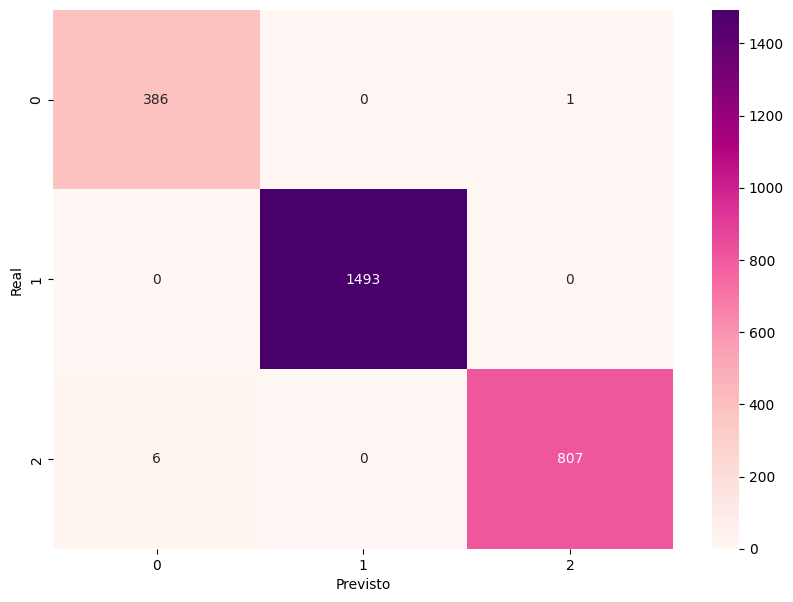

In [41]:
y_predito = modelo.predict(X_teste)

acuracia = accuracy_score(y_teste, y_predito)
print("Acurácia:", acuracia)
print(classification_report(y_teste, y_predito))

matriz_confusao = confusion_matrix(y_teste, y_predito)
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusao, annot=True, cmap='RdPu', fmt='g')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()
